In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Loading data:

In [4]:
data = pd.read_csv('data/all_data.csv').T
labels = pd.read_csv('data/labels.csv')

## Preprocessing indexes:

In [5]:
labels.drop('type_sample', axis=1, inplace=True)
labels = labels.reset_index(drop=True)
labels.rename(columns={ labels.columns[0]: "Participant" }, inplace=True)
labels.IBD = labels.IBD.astype('bool')

data = data.reset_index()
data.columns = data.iloc[0]
data = data.iloc[1:]
data = data.reset_index(drop=True)
data.rename(columns={ data.columns[0]: "Participant" }, inplace=True)

In [6]:
def split_data(data, seed = 43, train_val_test_split = (80,10,10)):
    indices = np.arange(len(data))
    np.random.seed(seed)
    np.random.shuffle(indices)
    train_indices = indices[:train_val_test_split[0]*len(indices)//100]
    val_indices = indices[train_val_test_split[0]*len(indices)//100:train_val_test_split[0]*len(indices)//100\
                          + train_val_test_split[1]*len(indices)//100]
    test_indices = indices[train_val_test_split[0]*len(indices)//100+ train_val_test_split[1]*len(indices)//100:]
    
    return data.iloc[train_indices], data.iloc[val_indices], data.iloc[test_indices]

In [7]:
train_data, val_data, test_data = split_data(data)
train_labels, val_labels, test_labels = split_data(labels)

## SVM

In [8]:
def svec(my_data, labels, weight = 1, print_stats = True):
    
    from sklearn.svm import SVC
    from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

    
    clf = SVC(kernel='poly', degree=2).fit(my_data[0], labels[0]['IBD'])
    train_acc = clf.score(my_data[0], labels[0]['IBD'])
    val_acc = clf.score(my_data[1], labels[1]['IBD'])
    
    if print_stats:
        print('Training accuracy: ', train_acc)
        print('Validation accuracy: ',val_acc)
        
        train_pred = clf.predict(my_data[0])
        val_pred = clf.predict(my_data[1])

        print("Training Statistics")
        print("ROC score = {}".format(roc_auc_score(labels[0]['IBD'], train_pred)))
        print("\nClassification Report:") 
        print(classification_report(labels[0]['IBD'], train_pred))
        print("\nConfusion Matrix:")
        print(confusion_matrix(labels[0]['IBD'], train_pred))
        print("")
        print("")
        print("Validation Statistics")
        print("ROC score = {}".format(roc_auc_score(labels[1]['IBD'], val_pred)))
        print("\nClassification Report:") 
        print(classification_report(labels[1]['IBD'], val_pred))
        print("\nConfusion Matrix:")
        print(confusion_matrix(labels[1]['IBD'], val_pred))
    
    return train_acc, val_acc
    


    
# clf = LogisticRegression(C = 1, random_state=0, solver='liblinear',\
#                          multi_class='ovr').fit(train_data.iloc[:, 1:], train_labels['IBD'])


In [9]:
svec((train_data.iloc[:,1:],val_data.iloc[:,1:]), (train_labels, val_labels))

Training accuracy:  1.0
Validation accuracy:  0.7752808988764045
Training Statistics
ROC score = 1.0

Classification Report:
             precision    recall  f1-score   support

      False       1.00      1.00      1.00       187
       True       1.00      1.00      1.00       525

avg / total       1.00      1.00      1.00       712


Confusion Matrix:
[[187   0]
 [  0 525]]


Validation Statistics
ROC score = 0.6944444444444444

Classification Report:
             precision    recall  f1-score   support

      False       0.65      0.50      0.57        26
       True       0.81      0.89      0.85        63

avg / total       0.76      0.78      0.77        89


Confusion Matrix:
[[13 13]
 [ 7 56]]


(1.0, 0.7752808988764045)

In [10]:
train_accuracy = []
val_accuracy = []

for i in range(11):
    weight = 1/(10**i)
    t,v = svec((train_data.iloc[:,1:],val_data.iloc[:,1:]), (train_labels, val_labels), weight, False)
    train_accuracy.append(t)
    val_accuracy.append(v)


[Text(0,0.5,'Accuracy'), Text(0.5,0,'Regularization Strength')]

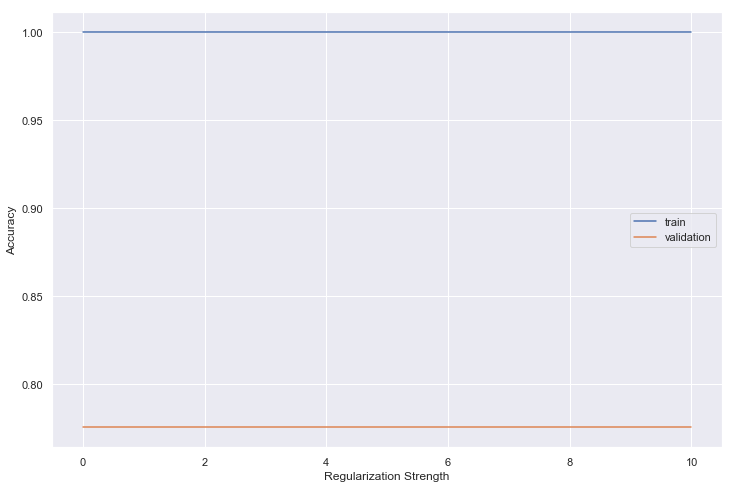

In [11]:
plt.rcParams["figure.figsize"] = (12,8)
import seaborn as sns
sns.set(style="darkgrid")
ax = sns.lineplot(list(range(11)),train_accuracy, label = 'train')
sns.lineplot(list(range(11)),val_accuracy, label = 'validation')
ax.set(xlabel='Regularization Strength', ylabel='Accuracy')


In [80]:
# def feature_correlation(data):
#     data = data[data.columns[1:]].reset_index()[data.columns[1:]].astype(float)
#     data.columns = np.arange(data.shape[1])
#     return data.corr()

In [ ]:
# fasta_file = 'dna-fragments.fasta'

# fasta_dict = dict()

# with open(fasta_file) as file:
#     for i, line in enumerate(file):
#         if i%2 == 0:
#             fragment = line[1:-1]
#         else:
#             fasta_dict[fragment] = line[:-1]

# np.save('fasta_dict.npy', fasta_dict)

In [ ]:
# max, sum_branch, single_linkage

In [178]:
#clusters
fasta_dict = np.load('fasta_dict.npy').item()

cluster_file = './clusters/clusters_single_linkage_10.csv'
clusters = pd.read_csv(cluster_file, sep='\t')

total_clusters = np.max(clusters['ClusterNumber'])

clustered_data = []
cluster_size = [0]

for i in range(1,total_clusters+1):
    cluster_size.append(cluster_size[i-1]+len(clusters[clusters['ClusterNumber'] == i]))
    clustered_data.append(data[[fasta_dict[c] for c in clusters[clusters['ClusterNumber'] == i]['SequenceName'].values]])
    
    

single_data = data[[fasta_dict[c] for c in clusters[clusters['ClusterNumber'] == -1]['SequenceName'].values]]


In [179]:
clustered_data.append(single_data)
cluster_size += list(range(cluster_size[-1],single_data.shape[1]+cluster_size[-1]))

In [180]:
clustered_data = pd.concat(clustered_data, axis = 1)

In [181]:
train_data, val_data, test_data = split_data(clustered_data)
train_labels, val_labels, test_labels = split_data(labels)

## PCA

## Standardization


In [182]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
scalar.fit(train_data)

train_norm = scalar.transform(train_data)
val_norm = scalar.transform(val_data)
test_norm = scalar.transform(test_data)
# train_norm = train_data
# val_norm = val_data
# test_norm = test_data

In [142]:
# variance to account for

variance = 0.95
from sklearn.decomposition import PCA
# Make an instance of the Model
pca = PCA(n_components = 1)
# pca.fit(train_norm)

In [43]:
train_norm.shape

(712, 10072)

In [184]:
for i in range(1,len(cluster_size)):
    
    try:
        pca.fit(train_norm[:,cluster_size[i-1]:cluster_size[i]])
    except:
        continue
    print(i)
    if i ==1:
        pca_train_norm = pca.transform(train_norm[:,cluster_size[i-1]:cluster_size[i]])
        pca_val_norm = pca.transform(val_norm[:,cluster_size[i-1]:cluster_size[i]])
        pca_test_norm = pca.transform(test_norm[:,cluster_size[i-1]:cluster_size[i]])
    else:
        pca_train_norm = np.hstack((pca_train_norm, pca.transform(train_norm[:,cluster_size[i-1]:cluster_size[i]])))
        pca_val_norm = np.hstack((pca_val_norm, pca.transform(val_norm[:,cluster_size[i-1]:cluster_size[i]])))
        pca_test_norm = np.hstack((pca_test_norm, pca.transform(test_norm[:,cluster_size[i-1]:cluster_size[i]])))
#     pca_train_norm.append(pca.transform(train_norm[:,cluster_size[i-1]:cluster_size[i]]))
#     pca_val_norm.append(pca.transform(val_norm[:,cluster_size[i-1]:cluster_size[i]]))
#     pca_test_norm.append(pca.transform(test_norm[:,cluster_size[i-1]:cluster_size[i]]))

1
3
4
5
6
7


In [482]:
# 500, 100, 50, 25, 10

In [483]:
# print("Number of feature vectors: ",pca.n_components_)

In [124]:
# pca_train_norm = pca.transform(train_norm)
# pca_val_norm = pca.transform(val_norm)
# pca_test_norm = pca.transform(test_norm)

In [185]:
# clf = LogisticRegression(C = 1, random_state=0, solver='liblinear',\
#                          multi_class='ovr').fit(train_data.iloc[:, 1:], train_labels['IBD'])

svec((pca_train_norm,pca_val_norm), (train_labels, val_labels))

Training accuracy:  0.7415730337078652
Validation accuracy:  0.6966292134831461
Training Statistics
ROC score = 0.5097428062133945

Classification Report:
             precision    recall  f1-score   support

      False       0.80      0.02      0.04       187
       True       0.74      1.00      0.85       525

avg / total       0.76      0.74      0.64       712


Confusion Matrix:
[[  4 183]
 [  1 524]]


Validation Statistics
ROC score = 0.49206349206349204

Classification Report:
             precision    recall  f1-score   support

      False       0.00      0.00      0.00        26
       True       0.70      0.98      0.82        63

avg / total       0.50      0.70      0.58        89


Confusion Matrix:
[[ 0 26]
 [ 1 62]]


(0.7415730337078652, 0.6966292134831461)

In [186]:
svec((pca_train_norm,pca_test_norm), (train_labels, test_labels))

Training accuracy:  0.7415730337078652
Validation accuracy:  0.6629213483146067
Training Statistics
ROC score = 0.5097428062133945

Classification Report:
             precision    recall  f1-score   support

      False       0.80      0.02      0.04       187
       True       0.74      1.00      0.85       525

avg / total       0.76      0.74      0.64       712


Confusion Matrix:
[[  4 183]
 [  1 524]]


Validation Statistics
ROC score = 0.5

Classification Report:
             precision    recall  f1-score   support

      False       0.00      0.00      0.00        30
       True       0.66      1.00      0.80        59

avg / total       0.44      0.66      0.53        89


Confusion Matrix:
[[ 0 30]
 [ 0 59]]


/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(0.7415730337078652, 0.6629213483146067)